Import the basic libraries

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7fbff'


Read the Bicycle Dataset

In [2]:
hourlyBicycleDataset = pd.read_csv('./Bike-Sharing-Dataset/hour.csv')

Check the size of the dataset, features of an observations, and data type of each feature

In [3]:
hourlyBicycleDataset.shape

(17379, 17)

In [4]:
hourlyBicycleDataset.head(-1)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,17374,2012-12-31,1,1,12,18,0,1,1,2,0.26,0.2727,0.48,0.1343,10,112,122
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


In [5]:
hourlyBicycleDataset.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Drop Unnecessary Feature (Possibly will use in the future)

In [6]:
hourlyBicycleDataset = hourlyBicycleDataset.drop(['instant', 'dteday', 'holiday', 'yr', 'casual', 'registered'], axis=1)

In [7]:
hourlyBicycleDataset.head(3)

,season,mnth,hr,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,6,0,1,0.22,0.2727,0.80,0.0,32


Check if any data is missing

In [8]:
hourlyBicycleDataset.isna().sum()

season        0
mnth          0
hr            0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Data Plotting

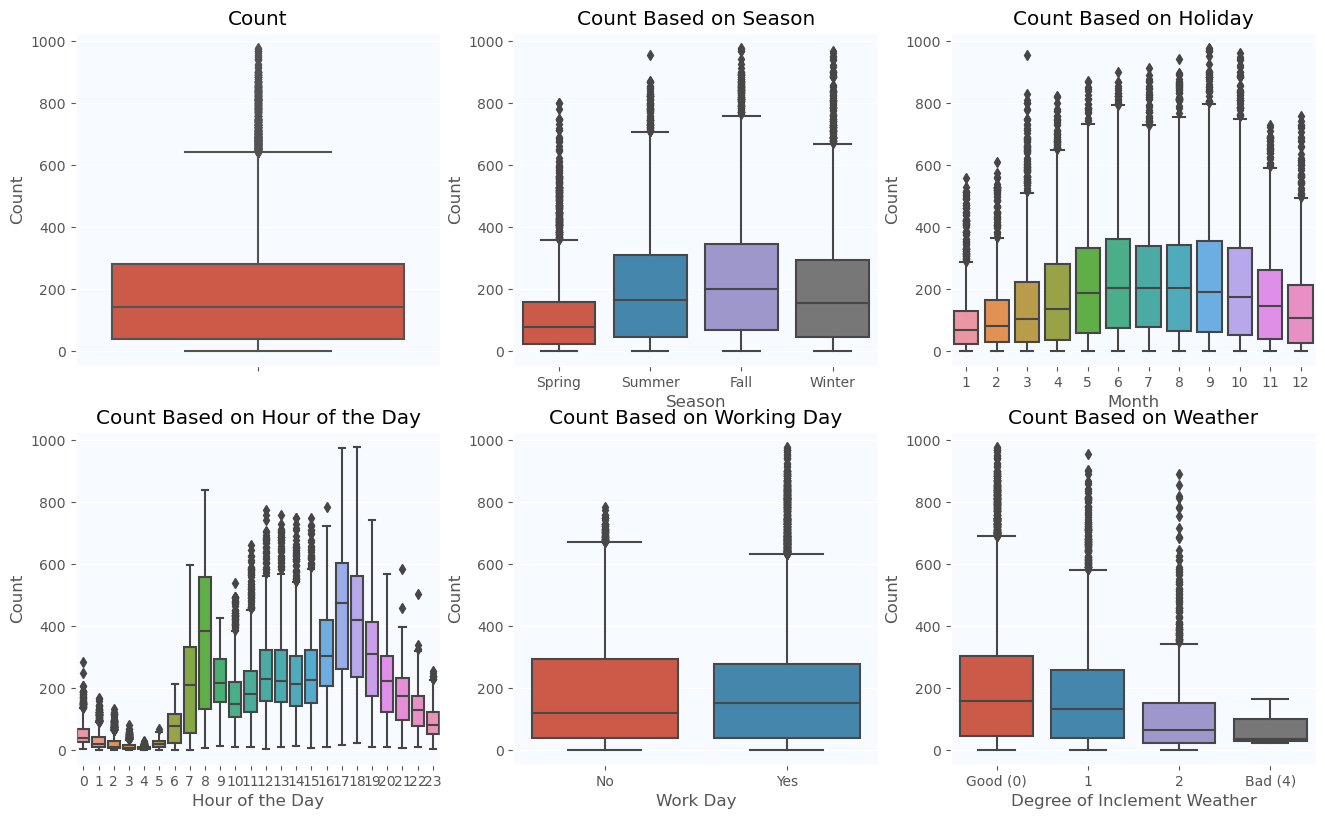

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 9.5)

sns.boxplot(data=hourlyBicycleDataset, y='cnt', ax=axes[0, 0])
sns.boxplot(data=hourlyBicycleDataset, x='season', y='cnt', ax=axes[0, 1])
sns.boxplot(data=hourlyBicycleDataset, x='mnth', y='cnt', ax=axes[0, 2])
sns.boxplot(data=hourlyBicycleDataset, x='hr', y='cnt', ax=axes[1, 0])
sns.boxplot(data=hourlyBicycleDataset, x='workingday', y='cnt', ax=axes[1, 1])
sns.boxplot(data=hourlyBicycleDataset, x='weathersit', y='cnt', ax=axes[1, 2])

axes[0, 0].set(ylabel='Count', title='Count')

axes[0, 1].set(xlabel='Season', ylabel='Count', title='Count Based on Season')
axes[0, 1].set_xticklabels( ('Spring', 'Summer', 'Fall', 'Winter'))

axes[0, 2].set(xlabel='Month', ylabel='Count', title='Count Based on Holiday')

axes[1, 0].set(xlabel='Hour of the Day', ylabel='Count', title='Count Based on Hour of the Day')

axes[1, 1].set(xlabel='Work Day', ylabel='Count', title='Count Based on Working Day')
axes[1, 1].set_xticklabels( ('No', 'Yes'))

axes[1, 2].set(xlabel='Degree of Inclement Weather', ylabel='Count', title='Count Based on Weather')
axes[1, 2].set_xticklabels( ('Good (0)', '1', '2', 'Bad (4)'))

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7fbff'

Here, we can see that numerous existing outliers, which could potentially bring down models' performance. Therefore, we will drop severe outliers.

In [10]:
mean = hourlyBicycleDataset['cnt'].mean()
std = hourlyBicycleDataset['cnt'].std()

hourlyBicycleDataset = hourlyBicycleDataset[np.abs(hourlyBicycleDataset['cnt'] - mean) <= 3*std]
hourlyBicycleDataset.shape

(17135, 11)

In [11]:
def changeNumToStr(month):
    if month == 0:
        return 'Sunday'
    elif month == 1:
        return 'Monday'
    elif month == 2:
        return 'Tuesday'
    elif month == 3:
        return 'Wednesday'
    elif month == 4:
        return 'Thursday'
    elif month == 5:
        return 'Friday'
    else:
        return 'Saturday'

In [12]:
def changeNumToSeason(season):
    if season == 1:
        return 'Spring'
    elif season == 2:
        return 'Summer'
    elif season == 3:
        return 'Fall'
    else:
        return 'Winter'

[Text(0.5, 0, 'Hour Of the Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Average Count over Hour Of The Day across Weekdays'),
 None]

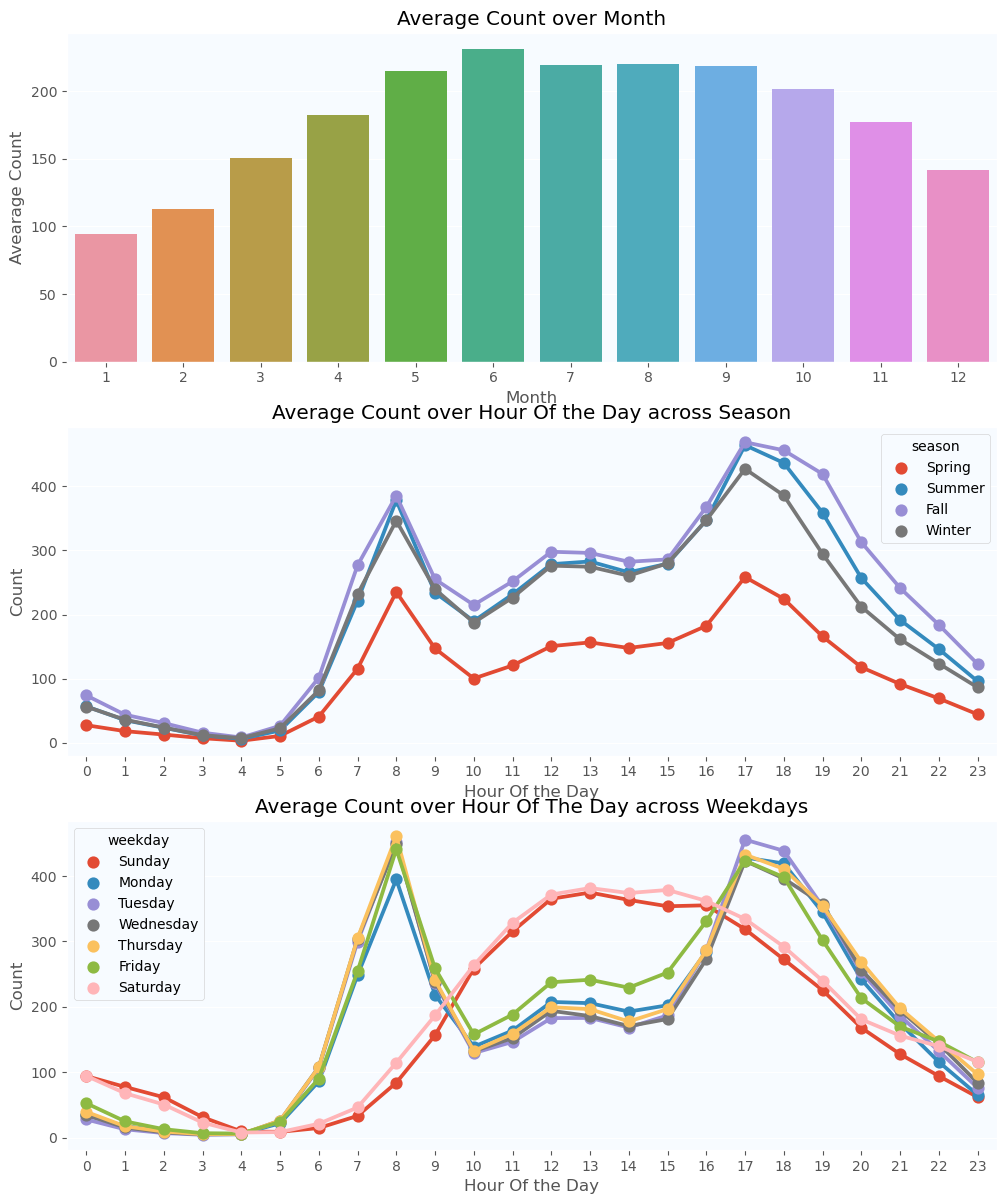

In [13]:
fig, (ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,14.5)

avgOverMonth = pd.DataFrame(hourlyBicycleDataset.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = avgOverMonth.sort_values(by="cnt", ascending=False)
sns.barplot(data=monthSorted, x="mnth", y="cnt", ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count over Month")

avgOverHour = pd.DataFrame(hourlyBicycleDataset.groupby(["hr", "season"], sort=True)["cnt"].mean()).reset_index()
avgOverHour['season'] = avgOverHour.season.apply(changeNumToSeason)
sns.pointplot(x=avgOverHour["hr"], y=avgOverHour["cnt"], hue=avgOverHour["season"], data=avgOverHour, join=True, ax=ax2)
ax2.set(xlabel='Hour Of the Day', ylabel='Count',title="Average Count over Hour Of the Day across Season", label='big')

avgOverHour = pd.DataFrame(hourlyBicycleDataset.groupby(["hr", "weekday"],sort=True)["cnt"].mean()).reset_index()
avgOverHour['weekday'] = avgOverHour.weekday.apply(changeNumToStr)
sns.pointplot(x=avgOverHour["hr"], y=avgOverHour["cnt"], hue=avgOverHour['weekday'], data=avgOverHour, join=True, ax=ax3)
ax3.set(xlabel='Hour Of the Day', ylabel='Count', title="Average Count over Hour Of The Day across Weekdays", label='big')

Correlation

<AxesSubplot: >

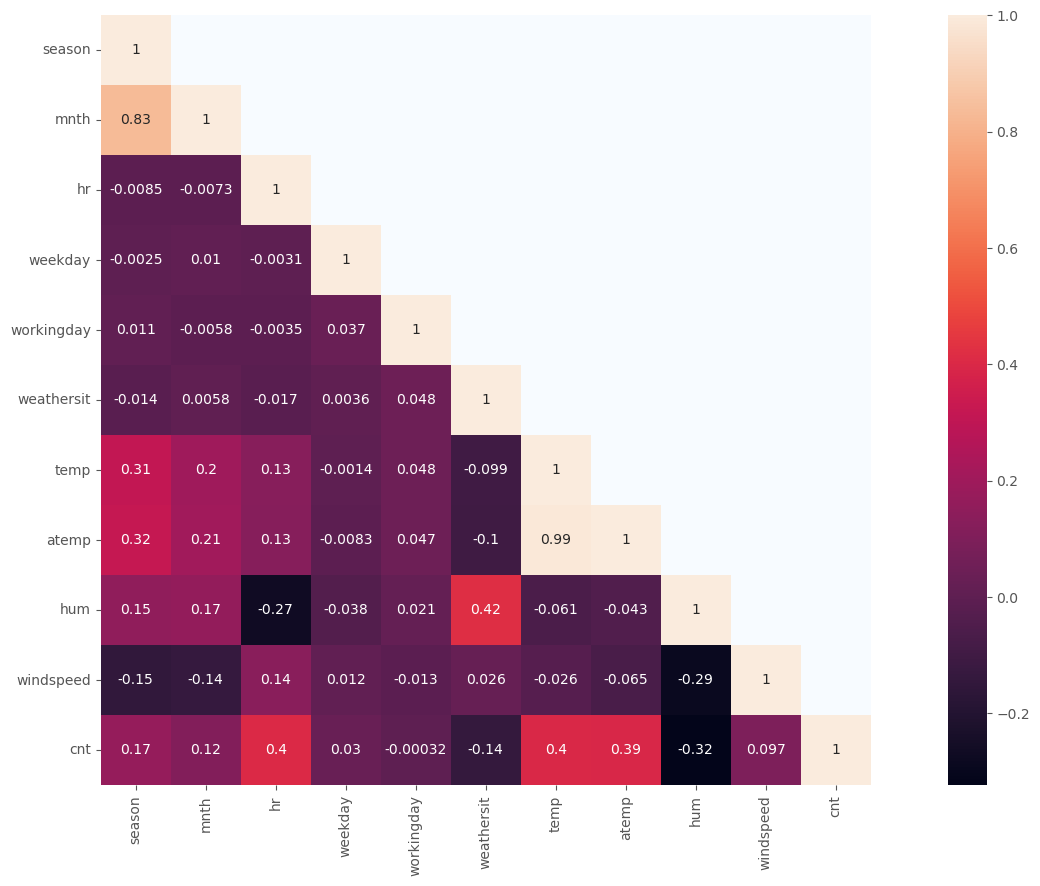

In [14]:
mask = hourlyBicycleDataset.corr()
mask = np.array(mask)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(hourlyBicycleDataset.corr(), mask=mask, annot=True, square=True)

It is noticeable that atemp and temp have high correlation that is close to 1, which shows that we need to drop one of them to avoid multi-collinearity.

From the regression plot/ scatter plot below, we can see that many observations of windspeed are 0.0, which suggests an idea that the data was not possibly observed.

[Text(0.5, 0, 'Humidity'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count over Humidity')]

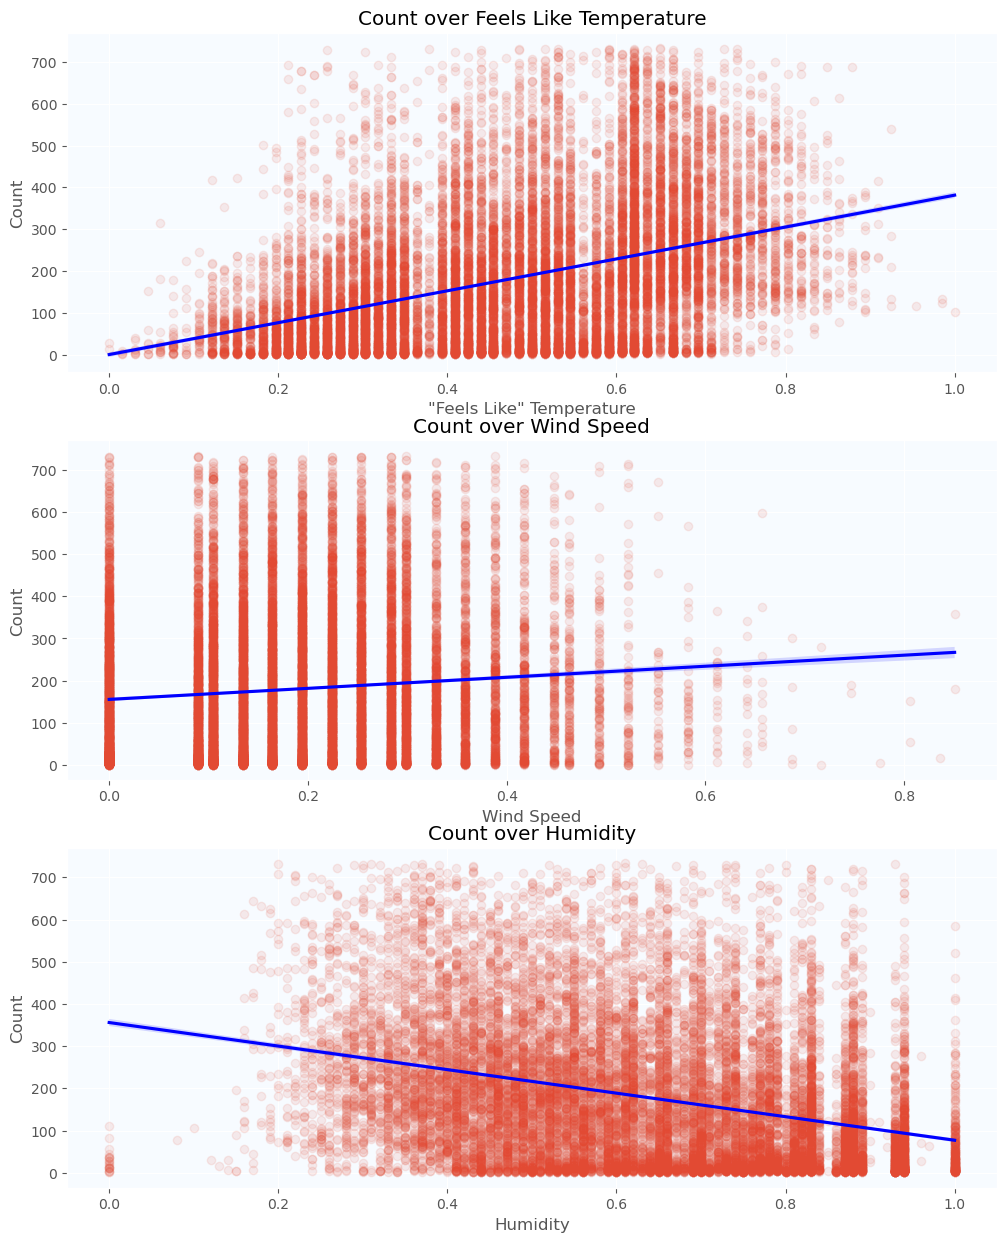

In [15]:
fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(12,15)
sns.regplot(x='atemp', y='cnt', data=hourlyBicycleDataset, ax=axes[0], scatter_kws={'alpha':0.1}, line_kws={'color':'blue'})
axes[0].set(xlabel='"Feels Like" Temperature', ylabel='Count', title="Count over Feels Like Temperature")

sns.regplot(x='windspeed', y='cnt', data=hourlyBicycleDataset, ax=axes[1], scatter_kws={'alpha':0.1}, line_kws={'color':'blue'})
axes[1].set(xlabel='Wind Speed', ylabel='Count', title="Count over Wind Speed")

sns.regplot(x='hum', y='cnt', data=hourlyBicycleDataset, ax=axes[2], scatter_kws={'alpha':0.1}, line_kws={'color':'blue'})
axes[2].set(xlabel='Humidity', ylabel='Count', title="Count over Humidity")

In [16]:
hourlyBicycleDataset.describe()

,season,mnth,hr,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000,17135.000000
mean,2.494718,6.522264,11.485848,3.003793,0.678669,1.428246,0.494417,0.473547,0.628875,0.189893,180.490516
std,1.109381,3.451943,6.931725,2.013274,0.467001,0.640886,0.192284,0.171711,0.192907,0.122455,166.101082
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,4.000000,6.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,39.000000
50%,2.000000,7.000000,11.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,139.000000
75%,3.000000,10.000000,17.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.790000,0.253700,273.000000
max,4.000000,12.000000,23.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,733.000000


In [17]:
categorized_col = ['season', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
for col in categorized_col:
    hourlyBicycleDataset[col] = hourlyBicycleDataset[col].astype('category')

hourlyBicycleDataset = hourlyBicycleDataset.drop(['temp'], axis=1)

In [18]:
hourlyBicycleDataset.dtypes

season        category
mnth          category
hr            category
weekday       category
workingday    category
weathersit    category
atemp          float64
hum            float64
windspeed      float64
cnt              int64
dtype: object

Now, we will dive the dataset into training set and testing set and fill out windspeed == 0 observations using random forest technique.

In [72]:
Y_col = 'cnt'
X_cols = hourlyBicycleDataset.drop(Y_col, axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(hourlyBicycleDataset[X_cols], hourlyBicycleDataset[Y_col], test_size=0.2, random_state=42)

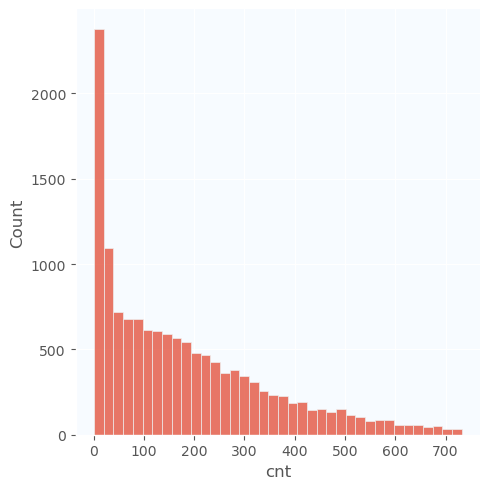

In [73]:
sns.displot(y_train)

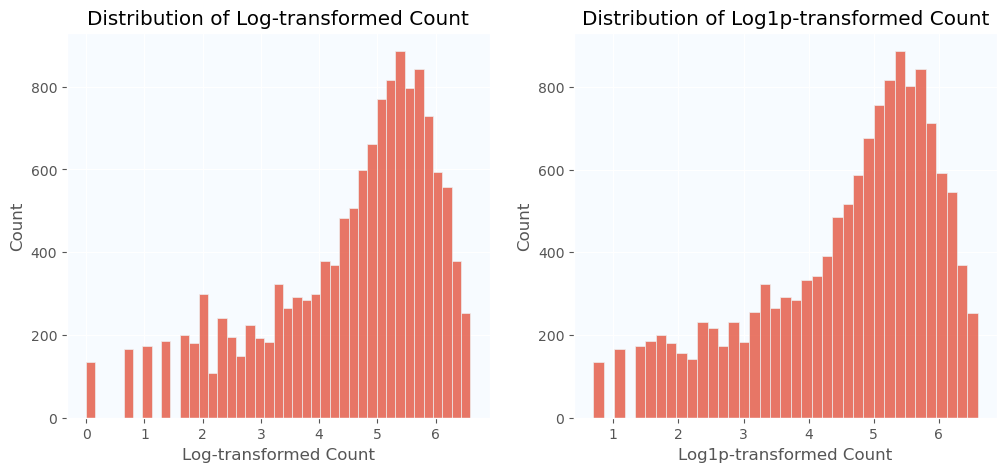

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.histplot(np.log(y_train), ax=axs[0])
axs[0].set_title("Distribution of Log-transformed Count")
axs[0].set_xlabel("Log-transformed Count")
axs[0].set_ylabel("Count")

sns.histplot(np.log1p(y_train), ax=axs[1])
axs[1].set_title("Distribution of Log1p-transformed Count")
axs[1].set_xlabel("Log1p-transformed Count")
axs[1].set_ylabel("Count")

plt.show()

In [177]:
RMSLEs = []
R2s = []

In [178]:
LinearRegressionModel = LinearRegression()
y_train_log1p = np.log1p(y_train)

LinearRegressionModel.fit(X_train, y_train_log1p)
y_pred = LinearRegressionModel.predict(X_test)
y_pred = np.expm1(y_pred)
RMSLEs.append(mean_squared_log_error(y_test, y_pred))
R2s.append(r2_score(y_test, y_pred))


In [179]:
print('RMSLE Value For Linear Regression: {}'.format(mean_squared_log_error(y_test, y_pred)))
print('R2 Score For Linear Regression: {}'.format(r2_score(y_test, y_pred)))

RMSLE Value For Linear Regression: 1.0836044836725178
R2 Score For Linear Regression: 0.11738326007482247


In [188]:
ridge = Ridge()
ridge_params = {'max_iter':[3000],'alpha':[0.001,0.01,0.1,1,10,100,1000]}
rmsle_scorer = metrics.make_scorer(mean_squared_log_error, greater_is_better=False)
grid_ridge = GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5)
grid_ridge.fit(X_train, y_train_log1p)

alphas = ridge_params['alpha']
rmsle_scores1 = -grid_ridge.cv_results_['mean_test_score']

y_pred = grid_ridge.predict(X_test)
y_pred = np.expm1(y_pred)
RMSLEs.append(mean_squared_log_error(y_test, y_pred))
R2s.append(r2_score(y_test, y_pred))

print (grid_ridge.best_params_)
print ("RMSLE Value For Ridge Regression: ",mean_squared_log_error(y_test, y_pred))
print('R2 Score For Linear Regression: {}'.format(r2_score(y_test, y_pred)))


{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  1.083604430284494
R2 Score For Linear Regression: 0.11738345122491745


In [181]:
lasso = Lasso()
lasso_params = {'max_iter':[3000],'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_lasso = GridSearchCV(lasso, lasso_params, scoring=rmsle_scorer,cv=5)
grid_lasso.fit(X_train, y_train_log1p)

alphas = lasso_params['alpha']
rmsle_scores2 = -grid_lasso.cv_results_['mean_test_score']

y_pred = grid_lasso.predict(X_test)
y_pred = np.expm1(y_pred)

RMSLEs.append(mean_squared_log_error(y_test, y_pred))
R2s.append(r2_score(y_test, y_pred))
print (grid_lasso.best_params_)
print('RMSLE Value for Lasso Regression {}'.format(mean_squared_log_error(y_test, y_pred)))
print('R2 Score For Linear Regression: {}'.format(r2_score(y_test, y_pred)))

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value for Lasso Regression 1.0835196638848217
R2 Score For Linear Regression: 0.11729798550131088


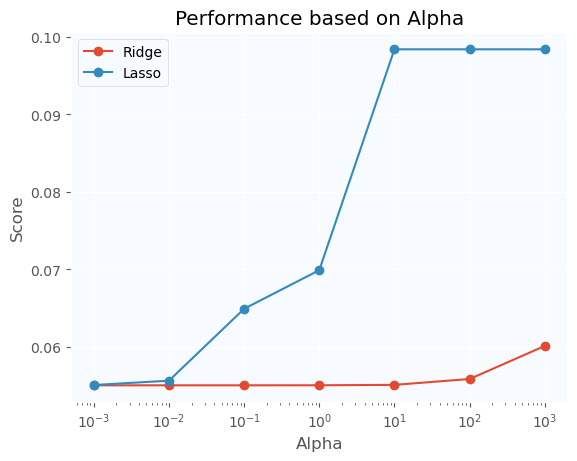

In [182]:
fig, ax = plt.subplots()

ax.plot(alphas, rmsle_scores1, marker='o', label='Ridge')
ax.plot(alphas, rmsle_scores2, marker='o', label='Lasso')
ax.set_xscale('log')
ax.set_title('Performance based on Alpha')
ax.set_xlabel('Alpha')
ax.set_ylabel('Score')
ax.legend()
plt.show()

In [183]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train_log1p)
y_pred = knn.predict(X_test)
y_pred = np.expm1(y_pred)
RMSLEs.append(mean_squared_log_error(y_test, y_pred))
R2s.append(r2_score(y_test, y_pred))
print('RMSLE Value for Lasso Regression {}'.format(mean_squared_log_error(y_test, y_pred)))
print('R2 Score For Linear Regression: {}'.format(r2_score(y_test, y_pred)))

RMSLE Value for Lasso Regression 0.1907700116917082
R2 Score For Linear Regression: 0.7979481470797015


In [184]:
data = {'Models':['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'KNeighborsRegressor'], 'RMSLE':RMSLEs, 'R2':R2s}
data = pd.DataFrame(data)
data

,Models,RMSLE,R2
0,Linear Regression,1.083604,0.117383
1,Ridge Regression,1.083604,0.117383
2,Lasso Regression,1.083520,0.117298
3,KNeighborsRegressor,0.190770,0.797948


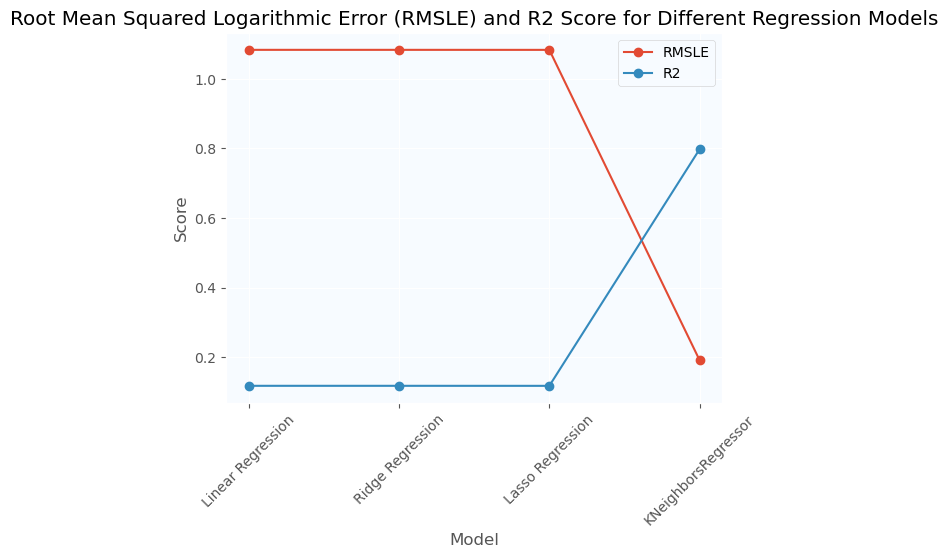

In [185]:
plt.plot(data['Models'], data['RMSLE'], marker='o', label='RMSLE')
plt.title('Root Mean Squared Logarithmic Error (RMSLE) and R2 Score for Different Regression Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.plot(data['Models'], data['R2'], marker='o', label='R2')
plt.grid(True, axis='y')
plt.legend()
plt.show()